Starting Football Match Outcome Predictor...
Training on 46 features. Columns: ['home_team_xg', 'away_team_xg', 'home_team_possession', 'away_team_possession', 'home_passing_onTarget', 'home_total_passing', 'away_passing_onTarget', 'away_total_passing', 'home_shots_onTarget', 'home_total_shots', 'away_shots_onTarget', 'away_total_shots', 'home_saves_onTarget', 'home_total_saves', 'away_saves_onTarget', 'away_total_saves', 'home_team_cards_number', 'away_team_cards_number', 'home_fouls', 'away_fouls', 'home_corners', 'away_corners', 'home_crosses', 'away_crosses', 'home_touches', 'away_touches', 'home_tackels', 'away_tackels', 'home_interceptions', 'away_interceptions', 'home_aerials', 'away_aerials', 'home_clearances', 'away_clearances', 'home_offsides', 'away_offsides', 'home_goal_kicks', 'away_goal_kicks', 'home_throw_ins', 'away_throw_ins', 'home_long_balls', 'away_long_balls', 'home_passes', 'away_passes', 'HomeTeam_ID', 'AwayTeam_ID']
Searching for optimal parameters...
----------

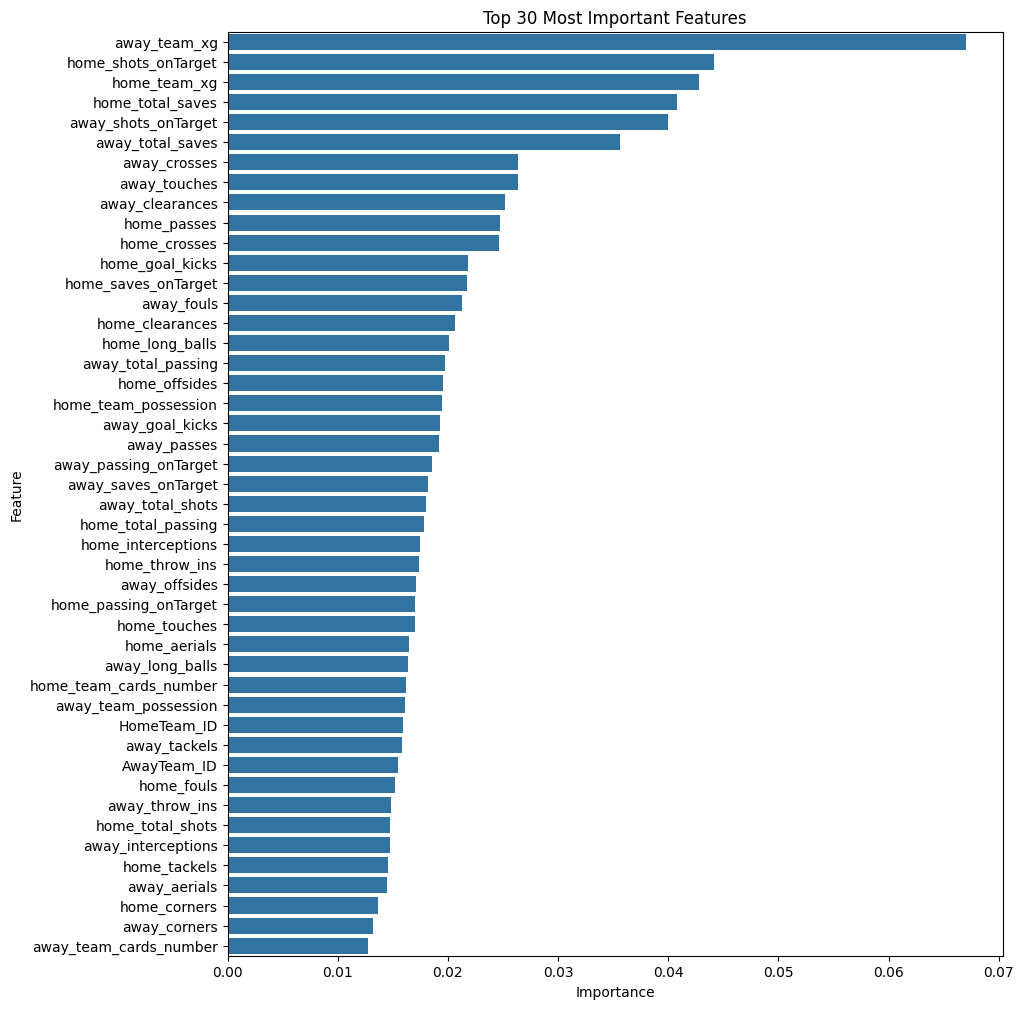

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

print("Starting Football Match Outcome Predictor...")

# ==========================================
# 1. LOAD & CLEAN
# ==========================================
df = pd.read_csv("match_data.csv") 

# Clean Possession (Remove %)
df['home_team_possession'] = pd.to_numeric(df['home_team_possession'].astype(str).str.rstrip('%'), errors='coerce').fillna(50) / 100.0
df['away_team_possession'] = pd.to_numeric(df['away_team_possession'].astype(str).str.rstrip('%'), errors='coerce').fillna(50) / 100.0

# Clean Other stats that might be strings (simple cleanup)
# If your CSV has data like "5 of 16" for shots, you need to parse that here.
# For now, we ensure all other columns intended to be numeric are actually numeric.
numeric_cols = [col for col in df.columns if 'score' not in col and 'name' not in col]
for col in numeric_cols:
    # Attempt to convert to numeric, turn errors (strings) into NaN
    if df[col].dtype == 'object':
         df[col] = pd.to_numeric(df[col], errors='coerce')

# 2. Fill missing values with the Team's Median/Average
# We group by team so we don't fill Real Madrid's missing data 
# with the league average (which would be too low for them).

def fillNA(column):
    # Calculate median per team
    home_passes_medians = df.groupby('home_team_name')[column].transform('median')
    away_passes_medians = df.groupby('away_team_name')[column].transform('median')

    # Fill the holes
    df[column] = df[column].fillna(home_passes_medians)
    df[column] = df[column].fillna(away_passes_medians)
columns = ["home_passing_onTarget","home_total_passing","away_passing_onTarget","away_total_passing","home_shots_onTarget","home_total_shots","away_shots_onTarget","away_total_shots","home_saves_onTarget","home_total_saves","away_saves_onTarget","away_total_saves","home_team_cards_number","away_team_cards_number","home_fouls","away_fouls","home_corners","away_corners","home_crosses","away_crosses","home_touches","away_touches","home_tackels","away_tackels","home_interceptions","away_interceptions","home_aerials","away_aerials","home_clearances","away_clearances","home_offsides","away_offsides","home_goal_kicks","away_goal_kicks","home_throw_ins","away_throw_ins","home_long_balls","away_long_balls"]

for col in columns:
    fillNA(col)

# ==========================================
# 2. ENCODE & PREPARE
# ==========================================
le = LabelEncoder()
all_teams = pd.concat([df['home_team_name'], df['away_team_name']]).unique()
le.fit(all_teams)
df['HomeTeam_ID'] = le.transform(df['home_team_name'])
df['AwayTeam_ID'] = le.transform(df['away_team_name'])

# Create Target
conditions = [
    (df['home_team_score'] > df['away_team_score']),
    (df['home_team_score'] == df['away_team_score']),
    (df['home_team_score'] < df['away_team_score'])
]
df['match_outcome'] = np.select(conditions, [2, 1, 0])

# ==========================================
# 3. DEFINE X and y (CRITICAL FIX)
# ==========================================

# List of columns that cannot go into the model
cols_to_drop = [
    'match_url', 
    'home_team_name', 'away_team_name', 
    'home_team_manager', 'away_team_manager', 
    'home_team_captain', 'away_team_captain', 
    'match_time', 'officials',
    # LEAKAGE PROTECTION: You must drop the result to predict the result
    'home_team_score', 'away_team_score', 
    'match_outcome'
]

# Create X by dropping text and result columns
X = df.drop(columns=cols_to_drop, errors='ignore')

# Ensure X only contains numeric data types
X = X.select_dtypes(include=[np.number])

y = df['match_outcome']

print(f"Training on {X.shape[1]} features. Columns: {list(X.columns)}")

# ==========================================
# 4. TRAINING
# ==========================================
split = int(len(df) * 0.85)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

tscv = TimeSeriesSplit(n_splits=4)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4], 
    'learning_rate': [0.01, 0.05],
    'colsample_bytree': [0.8],
    'subsample': [0.8]
}

print("Searching for optimal parameters...")
# Removed enable_categorical=True because we dropped the categories
clf = xgb.XGBClassifier(tree_method="hist", device="cuda")

grid = GridSearchCV(clf, param_grid, cv=tscv, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
preds = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)
acc = accuracy_score(y_test, preds)

print(f"-------------------------------")
print(f"MODEL ACCURACY: {acc:.2%}")
print(f"-------------------------------")

# High Confidence Check
results = pd.DataFrame({'Actual': y_test, 'Pred': preds, 'Conf': np.max(probs, axis=1)})
for t in [0.55, 0.60]:
    sub = results[results['Conf'] > t]
    print(f"Threshold {t}: {len(sub)} matches | Accuracy: {accuracy_score(sub['Actual'], sub['Pred']):.2%}")

importance = best_model.feature_importances_
feature_names = X.columns
# Create a DataFrame to look at the numbers
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# 4. VISUALIZE (The "Eye Test")
plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=fi_df) # Top 30
plt.title('Top 30 Most Important Features')
plt.show()

In [52]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Optional: Show what the model actually learned (Feature Importance)
importance = pd.DataFrame({
    'Feature': X.columns,
    'Score': best_model.feature_importances_
}).sort_values(by='Score', ascending=False)

print("Top 5 Key Predictors:")
print(importance.head(5))

# Get probabilities
probs = best_model.predict_proba(X_test)
results = pd.DataFrame({
    'Actual': y_test,
    'Pred': preds,
    'Conf': np.max(probs, axis=1) # Max probability (Confidence)
})

print(f"{'Threshold':<10} | {'Matches':<8} | {'Accuracy':<10} | {'Status'}")
print("-" * 50)

# Loop through thresholds from 40% to 60%
for threshold in [0.40, 0.45, 0.50, 0.55, 0.60]:
    # Filter bets with confidence > threshold
    subset = results[results['Conf'] > threshold]
    
    if len(subset) > 0:
        acc = accuracy_score(subset['Actual'], subset['Pred'])
        
        # Determine if this is a good strategy
        status = "POOR"
        if acc > 0.50: status = "OK"
        if acc > 0.55: status = "GOOD"
        if acc > 0.60: status = "EXCELLENT"
        
        print(f"{threshold:.2f}       | {len(subset):<8} | {acc:.2%}     | {status}")
    else:
        print(f"{threshold:.2f}       | 0        | N/A        | -")

Top 5 Key Predictors:
              Feature     Score
5  Specific_Form_Diff  0.215567
3       Home_HomeForm  0.140673
9       Away_Gen_Poss  0.121955
8       Home_Gen_Poss  0.120526
6         Home_Gen_XG  0.079521
Threshold  | Matches  | Accuracy   | Status
--------------------------------------------------
0.40       | 176      | 54.55%     | OK
0.45       | 140      | 57.14%     | GOOD
0.50       | 109      | 61.47%     | EXCELLENT
0.55       | 69       | 66.67%     | EXCELLENT
0.60       | 43       | 69.77%     | EXCELLENT


## Loading and Using model

In [ ]:
import pandas as pd
import numpy as np
import joblib
from scipy.optimize import minimize
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# 1. LOAD THE ELO MODEL
# ==========================================
print("Loading ELO model...")
try:
    data = joblib.load('football_elo_model.pkl')
    best_model = data['model']
    team_stats = data['stats']
    le = data['encoder']
    print("ELO Model Loaded Successfully!")
except FileNotFoundError:
    print("Error: 'football_elo_model.pkl' not found.")
    exit()

# ==========================================
# 2. FEATURE GENERATION (ELO LOGIC)
# ==========================================
def get_match_features_elo(home_name, away_name, team_stats):
    if home_name not in team_stats or away_name not in team_stats:
        return None, f"One or both teams ({home_name}, {away_name}) not found."

    h = team_stats[home_name]
    a = team_stats[away_name]

    def get_avg(hist, window=5):
        if not hist: return 0
        return sum(hist[-window:]) / min(len(hist), window)

    # Extract Data (using .get() for safety)
    features = {
        'Home_Elo': h.get('elo', 1500),
        'Away_Elo': a.get('elo', 1500),
        'Elo_Diff': h.get('elo', 1500) - a.get('elo', 1500),
        
        'Home_HomeForm': get_avg(h.get('pts_home', [])),
        'Away_AwayForm': get_avg(a.get('pts_away', [])),
        'Specific_Form_Diff': get_avg(h.get('pts_home', [])) - get_avg(a.get('pts_away', [])),
        
        'Home_Gen_XG': get_avg(h.get('xg_all', [])),
        'Away_Gen_XG': get_avg(a.get('xg_all', [])),
        'Home_Gen_Poss': get_avg(h.get('poss_all', [])),
        'Away_Gen_Poss': get_avg(a.get('poss_all', []))
    }
    
    # EXACT column order from training
    cols = [
        'Home_Elo', 'Away_Elo', 'Elo_Diff',
        'Home_HomeForm', 'Away_AwayForm', 'Specific_Form_Diff',
        'Home_Gen_XG', 'Away_Gen_XG',
        'Home_Gen_Poss', 'Away_Gen_Poss'
    ]
    
    return pd.DataFrame([features], columns=cols), None

# ==========================================
# 3. OPTIMIZER ENGINE
# ==========================================
def optimize_stakes(all_bets, bankroll, max_risk, kelly_fraction):
    profitable_bets = []
    
    for bet in all_bets:
        p = bet['Model_Prob']
        odds = bet['Bookie_Odds']
        if odds <= 1: continue
        
        b = odds - 1
        q = 1 - p
        ev = (p * b) - q
        
        # Filter: Positive Edge Only
        if ev > 0.005: 
            profitable_bets.append({
                'Match': bet['Match_ID'],
                'Pick': bet['Pick'],
                'Prob': p,
                'Odds': odds,
                'b': b,
                'EV': ev
            })

    if not profitable_bets:
        return pd.DataFrame(), "No profitable bets found."

    n = len(profitable_bets)
    
    def objective(stakes):
        growth = 0
        for i, bet in enumerate(profitable_bets):
            f = stakes[i]
            if 1 - f <= 0: return np.inf
            growth += bet['Prob'] * np.log(1 + f * bet['b']) + (1 - bet['Prob']) * np.log(1 - f)
        return -growth

    cons = [{'type': 'ineq', 'fun': lambda x: max_risk - np.sum(x)}]
    bounds = [(0, max_risk) for _ in range(n)]
    guess = np.array([max_risk / (n*2)] * n)
    
    result = minimize(objective, guess, method='SLSQP', bounds=bounds, constraints=cons)

    if not result.success: return pd.DataFrame(), "Optimization failed."

    output = []
    optimal_stakes = result.x * kelly_fraction 
    
    for i, bet in enumerate(profitable_bets):
        stake_pct = optimal_stakes[i]
        cash = bankroll * stake_pct
        
        if cash > 1.00:
            fair_odds = 1 / bet['Prob']
            output.append({
                'Match': bet['Match'],
                'Pick': bet['Pick'],
                'Prob': f"{bet['Prob']:.1%}",
                'Real_Odds': bet['Odds'],
                'Fair_Odds': f"{fair_odds:.2f}",
                'Edge': f"{bet['EV']:.1%}",
                'Stake_%': f"{stake_pct:.2%}",
                'Cash': f"${cash:.2f}"
            })
            
    return pd.DataFrame(output), None

# ==========================================
# 4. EXECUTION WITH REAL ODDS
# ==========================================

# SETTINGS
BANKROLL = 1000  # Set your real bankroll here
MAX_RISK = 0.25   # Max 25% of bankroll for this entire batch
KELLY = 0.25      # Quarter Kelly Safety

# DATA EXTRACTED FROM YOUR IMAGE
upcoming_fixtures_with_odds = [
    # Today / Tonight
    {'Home': 'Tottenham Hotspur', 'Away': 'Liverpool', 'Home_Odds': 3.54, 'Draw_Odds': 3.60, 'Away_Odds': 2.08},
    {'Home': 'Everton', 'Away': 'Arsenal', 'Home_Odds': 6.17, 'Draw_Odds': 3.94, 'Away_Odds': 1.59},
    {'Home': 'Leeds United', 'Away': 'Crystal Palace', 'Home_Odds': 2.72, 'Draw_Odds': 3.19, 'Away_Odds': 2.76},
    
    # Tomorrow / Dec 22
    {'Home': 'Aston Villa', 'Away': 'Manchester United', 'Home_Odds': 2.11, 'Draw_Odds': 3.67, 'Away_Odds': 3.35},
    {'Home': 'Fulham', 'Away': 'Nottingham Forest', 'Home_Odds': 2.47, 'Draw_Odds': 3.26, 'Away_Odds': 2.99},
    
    # Boxing Day / Late Dec
    {'Home': 'Manchester United', 'Away': 'Newcastle United', 'Home_Odds': 2.12, 'Draw_Odds': 3.78, 'Away_Odds': 3.19},
    {'Home': 'Nottingham Forest', 'Away': 'Manchester City', 'Home_Odds': 4.91, 'Draw_Odds': 4.17, 'Away_Odds': 1.65},
    {'Home': 'Arsenal', 'Away': 'Brighton & Hove Albion', 'Home_Odds': 1.45, 'Draw_Odds': 4.61, 'Away_Odds': 7.12},
    {'Home': 'Brentford', 'Away': 'Bournemouth', 'Home_Odds': 2.26, 'Draw_Odds': 3.62, 'Away_Odds': 3.03},
    {'Home': 'Burnley', 'Away': 'Everton', 'Home_Odds': 4.14, 'Draw_Odds': 3.41, 'Away_Odds': 1.95},
    {'Home': 'Liverpool', 'Away': 'Wolverhampton Wanderers', 'Home_Odds': 1.22, 'Draw_Odds': 6.77, 'Away_Odds': 12.06},
    {'Home': 'West Ham United', 'Away': 'Fulham', 'Home_Odds': 2.70, 'Draw_Odds': 3.39, 'Away_Odds': 2.61},
    {'Home': 'Chelsea', 'Away': 'Aston Villa', 'Home_Odds': 1.84, 'Draw_Odds': 3.80, 'Away_Odds': 4.05},
    {'Home': 'Sunderland', 'Away': 'Leeds United', 'Home_Odds': 2.56, 'Draw_Odds': 3.33, 'Away_Odds': 2.77},
    {'Home': 'Crystal Palace', 'Away': 'Tottenham Hotspur', 'Home_Odds': 2.15, 'Draw_Odds': 3.42, 'Away_Odds': 3.36},
    {'Home': 'Manchester United', 'Away': 'Wolverhampton Wanderers', 'Home_Odds': 1.29, 'Draw_Odds': 5.90, 'Away_Odds': 9.80}
]

print("\nScanning market for value using ELO Model...")
all_bets = []

for f in upcoming_fixtures_with_odds:
    home, away = f['Home'], f['Away']
    match_id = f"{home} vs {away}"
    
    # Get Features
    feat, err = get_match_features_elo(home, away, team_stats)
    
    if err:
        # Try finding partial name matches if exact name fails
        print(f"Skipping {match_id}: {err}")
        continue
        
    probs = best_model.predict_proba(feat)[0] # [Away, Draw, Home]
    
    # Add potential bets
    all_bets.append({'Match_ID': match_id, 'Pick': 'Home', 'Model_Prob': probs[2], 'Bookie_Odds': f['Home_Odds']})
    all_bets.append({'Match_ID': match_id, 'Pick': 'Draw', 'Model_Prob': probs[1], 'Bookie_Odds': f['Draw_Odds']})
    all_bets.append({'Match_ID': match_id, 'Pick': 'Away', 'Model_Prob': probs[0], 'Bookie_Odds': f['Away_Odds']})

# Run Optimization
df_results, msg = optimize_stakes(all_bets, BANKROLL, MAX_RISK, KELLY)

print("\n" + "="*85)
print(f"OPTIMIZED ELO PORTFOLIO (Bankroll: ${BANKROLL})")
print("="*85)

if not df_results.empty:
    print(df_results.to_string(index=False))
    total = df_results['Cash'].str.replace('$','').astype(float).sum()
    print("-" * 85)
    print(f"TOTAL INVESTMENT: ${total:.2f} ({total/BANKROLL:.1%} of Bankroll)")
else:
    print(msg)

Loading ELO model...
ELO Model Loaded Successfully!

Scanning market for value using ELO Model...

OPTIMIZED ELO PORTFOLIO (Bankroll: $1000)
                                       Match Pick  Prob  Real_Odds Fair_Odds   Edge Stake_%   Cash
                          Everton vs Arsenal Home 28.0%       6.17      3.57  72.7%   0.53%  $5.26
        Nottingham Forest vs Manchester City Home 33.1%       4.91      3.02  62.7%   0.26%  $2.60
                          Burnley vs Everton Home 46.1%       4.14      2.17  90.9%   2.02% $20.16
        Liverpool vs Wolverhampton Wanderers Away 25.8%      12.06      3.88 210.6%   2.37% $23.72
Manchester United vs Wolverhampton Wanderers Away 21.7%       9.80      4.61 112.4%   1.06% $10.63
-------------------------------------------------------------------------------------
TOTAL INVESTMENT: $62.37 (6.2% of Bankroll)


In [48]:
import pandas as pd
import joblib

# Load the ELO Stats
# (Assuming 'team_stats' is loaded. If not, uncomment the lines below)
# data = joblib.load('football_elo_model.pkl')
# team_stats = data['stats']

def check_matchup_stats_elo(home, away):
    if home not in team_stats or away not in team_stats:
        print("One or both teams not found.")
        return

    h = team_stats[home]
    a = team_stats[away]
    
    # Helper to safe-get averages
    def get_avg(hist): return sum(hist[-5:]) / 5 if hist else 0
    def get_val(stats, key): return stats.get(key, 0)

    print(f"\n{'STATISTIC':<20} | {home.upper():<15} | {away.upper():<15} | {'EDGE'}")
    print("-" * 65)
    
    # 1. ELO RATING (The most important stat)
    h_elo = h.get('elo', 1500)
    a_elo = a.get('elo', 1500)
    print(f"{'ELO Rating':<20} | {str(round(h_elo, 0)):<15} | {str(round(a_elo, 0)):<15} | {'Home' if h_elo > a_elo else 'Away'}")

    # 2. FORM (Last 5 Games Points - using 'pts_all')
    h_form = get_avg(h.get('pts_all', []))
    a_form = get_avg(a.get('pts_all', []))
    print(f"{'Recent Form (Pts)':<20} | {h_form:<15.2f} | {a_form:<15.2f} | {'Home' if h_form > a_form else 'Away'}")

    # 3. ATTACK (Average xG - using 'xg_all')
    h_xg = get_avg(h.get('xg_all', []))
    a_xg = get_avg(a.get('xg_all', []))
    print(f"{'Attack (xG)':<20} | {h_xg:<15.2f} | {a_xg:<15.2f} | {'Home' if h_xg > a_xg else 'Away'}")

    # 4. POSSESSION (using 'poss_all')
    h_poss = get_avg(h.get('poss_all', []))
    a_poss = get_avg(a.get('poss_all', []))
    print(f"{'Possession':<20} | {h_poss:<15.1%} | {a_poss:<15.1%} | {'Home' if h_poss > a_poss else 'Away'}")

# Run it for the big anomaly
for upcoming_fixture in upcoming_fixtures_with_odds:
    check_matchup_stats_elo(upcoming_fixture["Home"],upcoming_fixture["Away"])


STATISTIC            | TOTTENHAM HOTSPUR | LIVERPOOL       | EDGE
-----------------------------------------------------------------
ELO Rating           | 1518.0          | 1547.0          | Away
Recent Form (Pts)    | 2.00            | 2.00            | Away
Attack (xG)          | 1.48            | 1.90            | Away
Possession           | 51.2%           | 53.0%           | Away

STATISTIC            | EVERTON         | ARSENAL         | EDGE
-----------------------------------------------------------------
ELO Rating           | 1538.0          | 1666.0          | Away
Recent Form (Pts)    | 2.60            | 1.60            | Home
Attack (xG)          | 1.32            | 1.74            | Away
Possession           | 42.0%           | 62.6%           | Away

STATISTIC            | LEEDS UNITED    | CRYSTAL PALACE  | EDGE
-----------------------------------------------------------------
ELO Rating           | 1464.0          | 1574.0          | Away
Recent Form (Pts)    | 1.40  

In [ ]:
import pandas as pd
import numpy as np
import joblib

# ==========================================
# 1. LOAD THE SAVED MODEL
# ==========================================
print("Loading model...")
data = joblib.load('football_model_optimized.pkl')

best_model = data['model']
team_stats = data['team_stats']
le = data['encoder']

print("Model Loaded Successfully!")

# ==========================================
# 2. PREDICTION FUNCTION
# ==========================================
def predict_weekend(mananger,matchups, model, team_stats, encoder):
    print(f"\n{'MATCHUP':<40} | {'HOME %':<7} | {'DRAW %':<7} | {'AWAY %':<7} | {'PREDICTION':<12} | {'ACTION'}")
    print("-" * 105)
    
    # Helper to calculate stats exactly like training
    def get_avg(hist, window=5):
        if not hist: return 0
        return sum(hist[-window:]) / min(len(hist), window)

    for home, away in matchups:
        # Check data exists
        if home not in team_stats or away not in team_stats:
            print(f"{home:<18} vs {away:<18} | ???     | ???     | ???     | N/A          | ❌ Unknown Team")
            continue
            
        h = team_stats[home]
        a = team_stats[away]
        
        # Build Features
        features = {
            'HomeTeam_ID': encoder.transform([home])[0],
            'AwayTeam_ID': encoder.transform([away])[0],
            'Home_Form_Pts': get_avg(h['pts']),
            'Away_Form_Pts': get_avg(a['pts']),
            'Form_Diff': get_avg(h['pts']) - get_avg(a['pts']),
            'Home_xG_Avg': get_avg(h['xg']),
            'Away_xG_Avg': get_avg(a['xg']),
            'xG_Diff': get_avg(h['xg']) - get_avg(a['xg']),
            'Home_xGA_Avg': get_avg(h['xga']),
            'Away_xGA_Avg': get_avg(a['xga']),
            'Def_Diff': get_avg(h['xga']) - get_avg(a['xga']),
            'Home_Poss_Avg': get_avg(h['poss']),
            'Away_Poss_Avg': get_avg(a['poss']),
            'Poss_Diff': get_avg(h['poss']) - get_avg(a['poss'])
        }
        
        row = pd.DataFrame([features])
        
        # Predict
        probs = model.predict_proba(row)[0]
        p_away, p_draw, p_home = probs[0], probs[1], probs[2]
        odds_away, odds_draw, odds_home = 1/probs[0], 1/probs[1], 1/probs[2]
        confidence = np.max(probs)
        pred_label = ['Away Win', 'Draw', 'Home Win'][np.argmax(probs)]
        
        # --- ACTION LOGIC (Based on your 72% Accuracy) ---
        action = "-"
        if confidence > 0.50: action = "Low Bet"
        if confidence > 0.55: action = "✅ BET"         # 65% Accuracy Zone
        if confidence > 0.60: action = "🔥 SNIPER BET"  # 72% Accuracy Zone
        
        if pred_label != 'Draw' and p_draw > 0.32: action += " (⚠️ Risky)"
        manager.calculate_bet(odds=odds_home, model_confidence=confidence, historic_accuracy=0.725)

        print(f"{home:<18} vs {away:<18} | {p_home:.1%} {odds_home:.1f}   | {p_draw:.1%} {odds_draw:.1f}   | {p_away:.1%} {odds_away:.1f}   | {pred_label:<12} | {action}")

# ==========================================
# 3. REAL FIXTURES (DEC 20-21, 2025)
# ==========================================
# Update this list with the matches you want to check today
weekend_games = [
    # Premier League
    ('Tottenham Hotspur', 'Liverpool'),
    ('Manchester City', 'West Ham United'),
    ('Aston Villa', 'Manchester United'),
    ('Everton', 'Arsenal'),
    ('Newcastle United', 'Chelsea'),
    
    # La Liga
    ('Real Madrid', 'Sevilla'),
    ('Villarreal', 'Barcelona'),
    ('Girona', 'Atlético Madrid'),
    
    # Serie A
    ('Juventus', 'Roma'),
    ('Napoli', 'Lazio')
]

# Run
predict_weekend(manager,weekend_games, best_model, team_stats, le)

Loading model...
Model Loaded Successfully!

MATCHUP                                  | HOME %  | DRAW %  | AWAY %  | PREDICTION   | ACTION
---------------------------------------------------------------------------------------------------------
Tottenham Hotspur  vs Liverpool          | 41.6% 2.4   | 25.4% 3.9   | 32.9% 3.0   | Home Win     | -
Manchester City    vs West Ham United    | 60.8% 1.6   | 22.9% 4.4   | 16.3% 6.1   | Home Win     | 🔥 SNIPER BET
Aston Villa        vs Manchester United  | 52.7% 1.9   | 22.0% 4.5   | 25.3% 3.9   | Home Win     | Low Bet
Everton            vs Arsenal            | 35.6% 2.8   | 20.8% 4.8   | 43.6% 2.3   | Away Win     | -
Newcastle United   vs Chelsea            | 37.8% 2.6   | 26.9% 3.7   | 35.3% 2.8   | Home Win     | -
Real Madrid        vs Sevilla            | 40.2% 2.5   | 26.6% 3.8   | 33.2% 3.0   | Home Win     | -
Villarreal         vs Barcelona          | 24.2% 4.1   | 20.7% 4.8   | 55.2% 1.8   | Away Win     | ✅ BET
Girona             

In [ ]:
def predict_weekend(matchups, model, team_stats, encoder):
